### TASK2: Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

With minibatching, the training is expected to be faster as it enables the training on GPU.

The code for batching is taken from the following link:

https://github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/8_RNN_LSTM_Model/BatchingSeqModels.ipynb

The results reported are as follows:

Top-1 Accuracy: 0.7599003735990038 Top-2 Accuracy: 0.862266500622665 <br>
CPU times: user 33min 58s, sys: 49.4 s, total: 34min 47s<br>
Wall time: 6min 27s

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import torch
import glob
import os
import unicodedata
import string
import numpy as np
import torch.optim as optim
from IPython.display import clear_output

In [8]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:1


### 1. Load data

In [9]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


#### 1.1 Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

In [10]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


#### 1.2 Build the category_lines dictionary, a list of names per language

In [11]:
# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Check that it worked

for c in all_categories[:2]:
    print(c)
    print(category_lines[c]) 

Arabic
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', 'Raha

#### All countries

In [12]:
print(category_lines.keys())

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])


#### Example: German names

In [13]:
print(category_lines['German'][:5])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']


### 2. Train Test Split

In [14]:
names = []
targets = []

for k,v in category_lines.items():
    for name in v:
        names.append(name)
        targets.append(k)

print(len(names))
print(len(targets))

20074
20074


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(names, targets, test_size = 0.2, random_state = 123, stratify = targets)

In [20]:
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  16059
The number of observations in the test data:  4015


### 3. Encode names

In [21]:
#function to create representation of the name
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) #Create a zeros tensor
    #iterate through all the characters in the name
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #Assign a value for each pos value
    return rep

In [22]:
#function to create vec representation of the language
def lang_rep(lang):
    return torch.tensor([all_categories.index(lang)], dtype = torch.long)


#### Example of name and language representation

In [23]:
#example of name representation
beau = name_rep("beau")
print(beau)
print(beau.shape)

lang = lang_rep("German")
print(lang)
print(lang.shape)
# print(all_categories)

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

### 4. Define model

In [24]:
#create simple rnn network 
import torch.nn as nn
class RNN_net(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size 
        # Applies a multi-layer Elman RNN with \tanhtanh or \text{ReLU}ReLU non-linearity to an input sequence.
        # nn.RNN()
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size)

### 5. Inference

In [25]:
#function to run interference
def infer(net, name, device = "cpu"):
    name_ohe = name_rep(name).to(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [26]:
#create hidden layers
n_hidden = 128 #hidden layers count

#number of languages
n_languages = len(category_lines.keys())
print("Total number of languages present: ", n_languages)

#initialize the network
net = RNN_net(input_size=n_letters, hidden_size=n_hidden, output_size=n_languages)

Total number of languages present:  18


In [27]:
#check for inference
net = net.to(device)
infer(net, "kumar", device = device)

tensor([[-2.9477, -3.0273, -2.9186, -2.9304, -2.8071, -2.7905, -2.8676, -2.9192,
         -3.0071, -2.7959, -2.8193, -2.8625, -2.9019, -2.8879, -3.0303, -2.8210,
         -2.9022, -2.8388]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)

In [28]:
input = name_rep('A')

# put stuff on GPU
input = input.to(device)
hidden = torch.zeros((1,1, n_hidden)).to(device)

output, next_hidden = net(input, hidden)
output

tensor([[-2.9957, -2.9867, -2.9632, -2.9747, -2.8603, -2.9040, -2.8793, -2.8131,
         -2.9525, -2.7328, -2.7486, -2.8436, -2.9248, -2.8446, -3.0442, -2.8433,
         -2.9362, -2.8418]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)

In [29]:
input = name_rep('Albert')
hidden = torch.zeros((1,1, n_hidden))

# put stuff on GPU
input = input.to(device)
hidden = hidden.to(device)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = net(input[i].reshape(1,1,-1), next_hidden)
    print(output)

tensor([[-2.9957, -2.9867, -2.9632, -2.9747, -2.8603, -2.9040, -2.8793, -2.8131,
         -2.9525, -2.7328, -2.7486, -2.8436, -2.9248, -2.8446, -3.0442, -2.8433,
         -2.9362, -2.8418]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)
tensor([[-3.0031, -2.9854, -2.9370, -3.0118, -2.7898, -2.8088, -2.7997, -2.8483,
         -2.9793, -2.7378, -2.8377, -2.8630, -2.9877, -2.9383, -3.0378, -2.7735,
         -2.9251, -2.8382]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9733, -3.0077, -2.9775, -2.9582, -2.8080, -2.7824, -2.7881, -2.8899,
         -2.9802, -2.7620, -2.8139, -2.8748, -2.8930, -2.9887, -3.0873, -2.8493,
         -2.8759, -2.7918]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9643, -2.9691, -2.8957, -2.9035, -2.8444, -2.7950, -2.8628, -2.9064,
         -3.0787, -2.7819, -2.8322, -2.8551, -2.9770, -2.9503, -3.0153, -2.8039,
         -2.8929, -2.7608]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9662, -3.0093, -2.9411, -2.9419, -2.

### 6. Visualization

In [30]:
#loading dataloader
# dataloader(2, X_train, y_train)

In [31]:
count = {}
for l in all_categories: 
    count[l] = 0
for k,v in category_lines.items():
    count[k] += len(v)

In [32]:
print(count)

{'Arabic': 2000, 'Chinese': 268, 'Czech': 519, 'Dutch': 297, 'English': 3668, 'French': 277, 'German': 724, 'Greek': 203, 'Irish': 232, 'Italian': 709, 'Japanese': 991, 'Korean': 94, 'Polish': 139, 'Portuguese': 74, 'Russian': 9408, 'Scottish': 100, 'Spanish': 298, 'Vietnamese': 73}


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


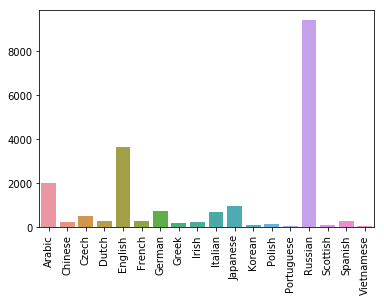

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

### 7. Dataloader & Evaluate Model

Check whether it works before training!

In [37]:
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    
    return to_ret

In [38]:
#loading dataloader
dataloader(2, X_train, y_train)

[('Molina',
  'Spanish',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [39]:
def eval(net, n_points, topk, X_, y_, device = "cpu"):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:

        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

In [44]:
#test the evaluation function
eval(net, 1000, 1, X_test, y_test)

0.068

### 8. Batching pytorch

In [45]:
#create a batched name rep

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [46]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [47]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

In [48]:
#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [49]:
out_ = batched_name_rep(['Beau', 'Ivo'], 5)
print_char(out_)

B
I
e
v
a
o
u
<pad>
<pad>
<pad>


In [50]:
batched_dataloader(2, X_train, y_train, True)

torch.Size([7, 2, 57]) torch.Size([14, 57])
--
['Atlanov', 'Egleton']
A
E
t
g
l
l
a
e
n
t
o
o
v
n
--
A
E
t
g
l
l
a
e
n
t
o
o
v
n
Lang Rep tensor([14,  4])
Batch sizes tensor([2, 2, 2, 2, 2, 2, 2])


(PackedSequence(data=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

### 10. Training
#### 10.1 Define train function

In [51]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [54]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

#### 10.2 Define loss and optimizer

In [58]:
net = RNN_net(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

#### 10.4 Actual training

In [59]:
%%time 
#time for normal training
train(net, opt, criterion, 256)

CPU times: user 6.65 s, sys: 503 ms, total: 7.16 s
Wall time: 1.68 s


tensor(2.8584, grad_fn=<DivBackward0>)

### 11. Full training setup

In [60]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))

Iteration 2999 Loss 0.5385945439338684


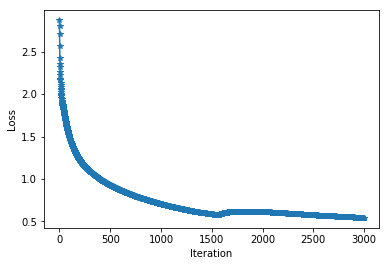




Top-1 Accuracy: 0.7599003735990038 Top-2 Accuracy: 0.862266500622665
CPU times: user 33min 58s, sys: 49.4 s, total: 34min 47s
Wall time: 6min 27s


In [63]:
%%time

#training RNN using batch technique
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=3200, batch_size = 512, display_freq=500) # CPU Training example